### Importing all the necessary libraries

In [1]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
import os
import pymongo
from pymongo import MongoClient
from pandas import json_normalize
import json
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specify the folder path where you want to save the Data
file_name = "Accidental_Drug_Related_Deaths_2012-2022.csv"

### Making the Directory Global

In [3]:
#To ensure your code is portable and the specified folder is accessible on any system,we are using
#environment variables and the Python os module to dynamically create paths based on the 
#user's system environment and creating the folder if not exist
# Getting the desktop directory
desktop_path = os.path.join(os.path.expanduser("~"), 'Desktop')
new_folder_path = os.path.join(desktop_path, 'DAP Project_teamSNS')
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
file_path = os.path.join(new_folder_path, file_name)
print(f"Directory created at: {new_folder_path}")
print(f"File path: {file_path}")

Directory created at: C:\Users\sanju\Desktop\DAP Project_teamSNS
File path: C:\Users\sanju\Desktop\DAP Project_teamSNS\Accidental_Drug_Related_Deaths_2012-2022.csv


### Extracting dataset through API

In [4]:
#Firstly we are Going to Extract our dataset through API
# URL to fetch CSV data
url = 'https://data.ct.gov/api/views/rybz-nyjw/rows.csv?accessType=DOWNLOAD'
# Make the GET request
response = requests.get(url)
print(response)
if response.status_code == 200:
    csv_data = StringIO(response.text)
    # Load data into a pandas DataFrame from the file-like object
    df = pd.read_csv(csv_data)
    # Save the DataFrame to CSV in the specified folder
    df.to_csv(file_path, index=False)
    print(f"Data saved to CSV file at: {file_path}")
else:
    print("Failed to retrieve data. Status code:", response.status_code)
print("Accidental_Drug_Related_Deaths_2012-2022 CSV DONE")

<Response [200]>
Data saved to CSV file at: C:\Users\sanju\Desktop\DAP Project_teamSNS\Accidental_Drug_Related_Deaths_2012-2022.csv
Accidental_Drug_Related_Deaths_2012-2022 CSV DONE


### Converting CSV into JSON

In [5]:
# Dataset names for CSV and JSON files
datasets = ["Accidental_Drug_Related_Deaths_2012-2022"]
def convert_and_cleanup(data_name):
    csv_file_path = f"{new_folder_path}\\{data_name}.csv"
    json_file_path = f"{new_folder_path}\\{data_name}.json"
    try:
        # Load CSV into DataFrame
        df = pd.read_csv(csv_file_path)
        # Convert DataFrame to JSON
        df.to_json(json_file_path, orient='records', lines=True)
        # Remove the original CSV file
        os.remove(csv_file_path)
        print(f"Converted {csv_file_path} to JSON and deleted the CSV file.")
    except Exception as e:
        print(f"An error occurred processing {data_name}: {e}")
for dataset in datasets:
    convert_and_cleanup(dataset)

Converted C:\Users\sanju\Desktop\DAP Project_teamSNS\Accidental_Drug_Related_Deaths_2012-2022.csv to JSON and deleted the CSV file.


### Dumping the JSON File in Mongodb database

In [6]:
# MongoDB connection
myclient = pymongo.MongoClient("mongodb://localhost:27017")
db = myclient['DAP']  # DAP is the name of the database
# File paths
Accidental_Data = f"{new_folder_path}\\Accidental_Drug_Related_Deaths_2012-2022.json"
# Inserting JSON data into MongoDB
try:
    collection2 = db.Accidental_Data
# Delete existing data in the collection
    collection2.delete_many({})  # This deletes all documents in the collection
    print("Existing data deleted from the collection2.")
    with open(Accidental_Data, 'r', encoding='utf-8') as file:
        for line in file:
            obj = json.loads(line)
            collection2.insert_one(obj)
    print("Accidental_Data data successfully inserted into MongoDB.")
except Exception as e:
    print("An error occurred while inserting JSON data:", e)

Existing data deleted from the collection2.
Accidental_Data data successfully inserted into MongoDB.


### Extracting data from mongodb into Dataframe

In [7]:
client = MongoClient()
#point the client at mongo URI
client = MongoClient('mongodb://localhost:27017')
#select database
db = client['DAP']
#select collection
test = db.Accidental_Data
#convert entire collection to pandas Dataframe
test =list(test.find())
df = json_normalize(test)
df.head() # displaying the first 5 data

_id        Date      Date Type   Age     Sex   Race  \
0  66340f10bd3c558ccdc8603c  05/29/2012  Date of death  37.0    Male  Black   
1  66340f10bd3c558ccdc8603d  06/27/2012  Date of death  37.0    Male  White   
2  66340f10bd3c558ccdc8603e  03/24/2014  Date of death  28.0    Male  White   
3  66340f10bd3c558ccdc8603f  12/31/2014  Date of death  26.0  Female  White   
4  66340f10bd3c558ccdc86040  01/16/2016  Date of death  41.0    Male  White   

  Ethnicity Residence City Residence County Residence State  ... Xylazine  \
0      None       STAMFORD        FAIRFIELD            None  ...     None   
1      None        NORWICH       NEW LONDON            None  ...     None   
2      None         HEBRON             None            None  ...     None   
3      None         BALTIC             None            None  ...     None   
4      None        SHELTON        FAIRFIELD              CT  ...     None   

  Gabapentin Opiate NOS Heroin/Morph/Codeine Other Opioid Any Opioid Other  \
0       None       None                 None         None       None  None   
1       None       None                 None         None       None  None   
2       None       None                 None         None       None  None   
3       None       None                 None         None       None  None   
4       None       None                 None         None          Y  None   

                        ResidenceCityGeo  \
0  STAMFORD, CT\n(41.051924, -73.539475)   
1   NORWICH, CT\n(41.524304, -72.075821)   
2    HEBRON, CT\n(41.658069, -72.366324)   
3    BALTIC, CT\n(41.617221, -72.085031)   
4   SHELTON, CT\n(41.316843, -73.092968)   

                           InjuryCityGeo  \
0  STAMFORD, CT\n(41.051924, -73.539475)   
1   NORWICH, CT\n(41.524304, -72.075821)   
2    HEBRON, CT\n(41.658069, -72.366324)   
3            CT\n(41.575155, -72.738288)   
4   SHELTON, CT\n(41.316843, -73.092968)   

                               DeathCityGeo  
0               CT\n(41.575155, -72.738288)  
1      Norwich, CT\n(41.524304, -72.075821)  
2  Marlborough, CT\n(41.632043, -72.461309)  
3       Baltic, CT\n(41.617221, -72.085031)  
4   Bridgeport, CT\n(41.179195, -73.189476)  

[5 rows x 49 columns]

In [8]:
#displaying the last 5 data
df.tail()

_id        Date      Date Type   Age   Sex  \
10649  66340f15bd3c558ccdc889d5  08/15/2022  Date of death  60.0  Male   
10650  66340f15bd3c558ccdc889d6  01/30/2022  Date of death  65.0  Male   
10651  66340f15bd3c558ccdc889d7  09/17/2022  Date of death  41.0  Male   
10652  66340f15bd3c558ccdc889d8  12/20/2022  Date of death  59.0  Male   
10653  66340f15bd3c558ccdc889d9  09/08/2022  Date of death  49.0  Male   

                            Race Ethnicity Residence City Residence County  \
10649                      White      None    SOUTHINGTON         HARTFORD   
10650                      White      None       HARTFORD         HARTFORD   
10651  Black or African American      None       HARTFORD         HARTFORD   
10652                      White      None       CHESHIRE        NEW HAVEN   
10653                      White      None  WEATHERSFIELD             None   

      Residence State  ... Xylazine Gabapentin Opiate NOS  \
10649              CT  ...     None       None       None   
10650              CT  ...     None          Y       None   
10651              CT  ...        Y       None       None   
10652              CT  ...        Y       None       None   
10653            None  ...     None       None       None   

      Heroin/Morph/Codeine   Other Opioid Any Opioid          Other  \
10649                 None           None          Y           None   
10650                    y  Buprenorphine          Y  Buprenorphine   
10651                 None           None          Y           None   
10652                 None           None          Y           None   
10653                 None           None          Y           None   

                                        ResidenceCityGeo  \
10649  SOUTHINGTON, CT\n(41.600220000000036, -72.8781...   
10650  HARTFORD, CT\n(41.76376000000005, -72.67397999...   
10651  HARTFORD, CT\n(41.76376000000005, -72.67397999...   
10652  CHESHIRE, CT\n(41.511690000000044, -72.8991099...   
10653           WEATHERSFIELD, CT\n(41.71109, -72.66228)   

                                           InjuryCityGeo  \
10649  SOUTHINGTON, CT\n(41.600220000000036, -72.8781...   
10650  HARTFORD, CT\n(41.76376000000005, -72.67397999...   
10651  HARTFORD, CT\n(41.76376000000005, -72.67397999...   
10652  CHESHIRE, CT\n(41.511690000000044, -72.8991099...   
10653  WETHERSFIELD, CT\n(41.71109000000007, -72.6622...   

                                      DeathCityGeo  
10649  CT\n(41.57350273000003, -72.73830590799997)  
10650  CT\n(41.57350273000003, -72.73830590799997)  
10651  CT\n(41.57350273000003, -72.73830590799997)  
10652  CT\n(41.57350273000003, -72.73830590799997)  
10653  CT\n(41.57350273000003, -72.73830590799997)  

[5 rows x 49 columns]

In [9]:
#Showing data infomation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10654 entries, 0 to 10653
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _id                            10654 non-null  object 
 1   Date                           10654 non-null  object 
 2   Date Type                      10654 non-null  object 
 3   Age                            10652 non-null  float64
 4   Sex                            10645 non-null  object 
 5   Race                           10625 non-null  object 
 6   Ethnicity                      1575 non-null   object 
 7   Residence City                 10148 non-null  object 
 8   Residence County               9486 non-null   object 
 9   Residence State                8756 non-null   object 
 10  Injury City                    10476 non-null  object 
 11  Injury County                  7332 non-null   object 
 12  Injury State                   7741 non-null  

In [10]:
#Checking for Dupliactes
df.nunique()

_id                              10654
Date                              3520
Date Type                            2
Age                                 70
Sex                                  2
Race                                14
Ethnicity                            8
Residence City                     513
Residence County                   152
Residence State                     34
Injury City                        295
Injury County                       17
Injury State                         6
Injury Place                        97
Description of Injury              478
Death City                         238
Death County                        10
Death State                          2
Location                            16
Location if Other                  543
Cause of Death                    6912
Manner of Death                      5
Other Significant Conditions       338
Heroin                               1
Heroin death certificate (DC)        1
Cocaine                  

In [11]:
#Missing Values Calculation
df.isnull().sum()

_id                                  0
Date                                 0
Date Type                            0
Age                                  2
Sex                                  9
Race                                29
Ethnicity                         9079
Residence City                     506
Residence County                  1168
Residence State                   1898
Injury City                        178
Injury County                     3322
Injury State                      2913
Injury Place                       290
Description of Injury              804
Death City                        1457
Death County                      2564
Death State                       3781
Location                            22
Location if Other                 9460
Cause of Death                       0
Manner of Death                      9
Other Significant Conditions      9644
Heroin                            7182
Heroin death certificate (DC)     9914
Cocaine                  

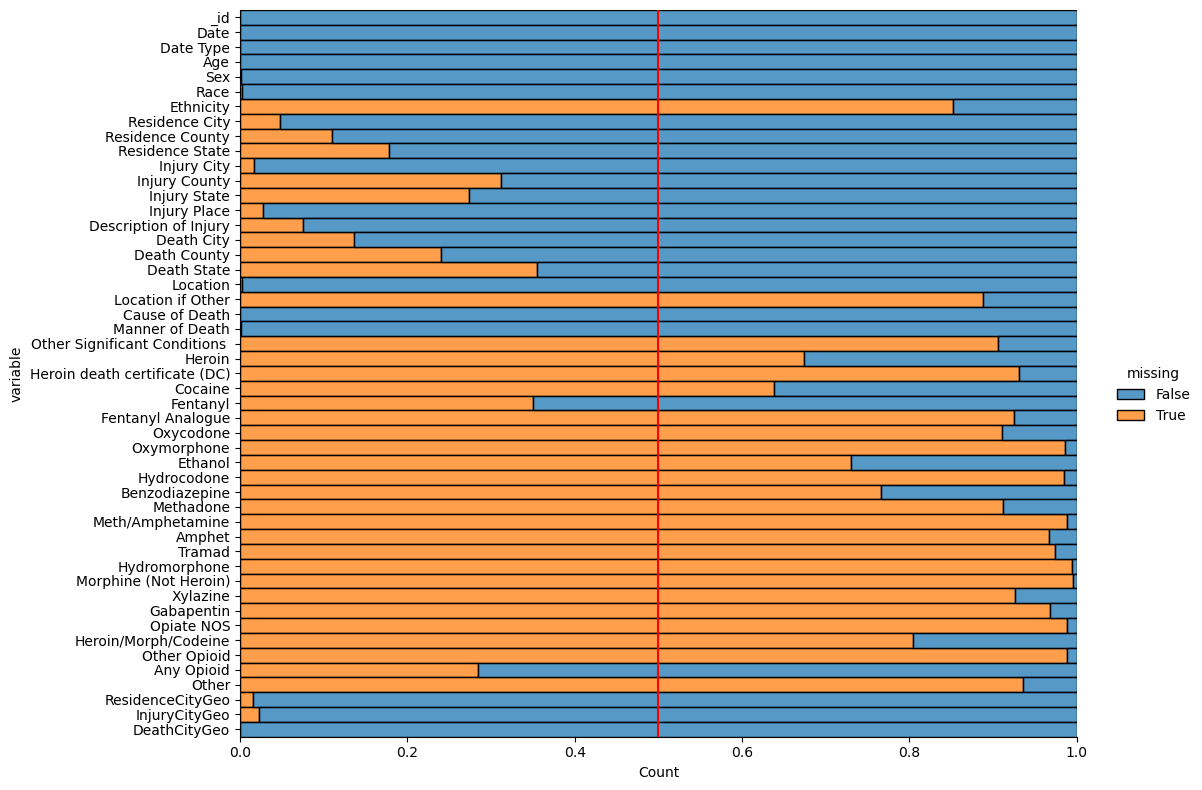

In [12]:
#idengifying null value by visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data=df.isnull().melt(value_name='missing'),y='variable',hue='missing',multiple='fill',height=8,aspect=1.4)
plt.axvline(0.5, color='r')

In [13]:
#Calculating the percentage of missing values
(df.isnull().sum()/(len(df)))*100

_id                               0.000000
Date                              0.000000
Date Type                         0.000000
Age                               0.018772
Sex                               0.084475
Race                              0.272198
Ethnicity                        85.216820
Residence City                    4.749390
Residence County                 10.963019
Residence State                  17.814905
Injury City                       1.670734
Injury County                    31.180777
Injury State                     27.341843
Injury Place                      2.721982
Description of Injury             7.546461
Death City                       13.675615
Death County                     24.066078
Death State                      35.489018
Location                          0.206495
Location if Other                88.792942
Cause of Death                    0.000000
Manner of Death                   0.084475
Other Significant Conditions     90.519992
Heroin     

### As we can see there are many null values are present in the dataset
1) Columns with No Missing Values (0% Null):-
id, Date, Date Type, Cause of Death, DeathCityGeo
2) Low Percentage of Missing Values (1% - 10% Null):-
Age, Sex, Residence City, Residence County, Injury City, Injury Place, Description of Injury, Location, Manner of Death, ResidenceCityGeo, InjuryCityGeo
3) Moderate Percentage of Missing Values (10% - 30% Null):- 
Residence State, Injury County, Injury State, Death City, Death County, Fentanyl, Any Opioid
4) High Percentage of Missing Values (30% - 50% Null):- 
Death State
5) Very High Percentage of Missing Values (Over 50% Null):-
Ethnicity, Location if Other, Other Significant Conditions, Heroin, Heroin death certificate (DC), Cocaine, Fentanyl Analogue, Oxycodone, Oxymorphone, Ethanol, Hydrocodone, Benzodiazepine, Methadone, Meth/Amphetamine, Amphet, Tramad, Hydromorphone, Morphine (Not Heroin), Xylazine, Gabapentin, Opiate NOS, Heroin/Morph/Codeine, Other Opioid, Other

In [14]:
#Age
#filling null age values with mean age and coverting it to integer type
age_mean = df['Age'].mean()
df['Age'] = df['Age'].fillna(age_mean)
df['Age'] = df['Age'].astype(int)
df['Age'].isnull().sum()

0

In [15]:
df['Race'].unique()

array(['Black', 'White', None, 'Other', 'Unknown', 'Asian Indian',
       'Black or African American', 'American Indian or Alaska Native',
       'Asian, Other', 'Other Asian', 'Hawaiian',
       'Native American, Other', 'Chinese', 'Korean', 'Asian/Indian'],
      dtype=object)

In [16]:
df['Age'].unique()

array([37, 28, 26, 41, 57, 64, 33, 23, 54, 45, 21, 48, 30, 49, 39, 44, 42,
       43, 46, 50, 35, 14, 31, 40, 68, 47, 51, 65, 52, 25, 59, 27, 34, 38,
       53, 56, 24, 36, 22, 63, 70, 60, 29, 32, 55, 61, 67, 19, 58, 66, 62,
       20, 18, 69, 73, 72, 71, 16, 74, 17, 77, 84, 75, 80, 81, 15, 78, 87,
       76, 13])

In [17]:
df['Ethnicity'].unique()

array([None, 'Hispanic', 'Other Spanish/Hispanic/Latino',
       'Spanish/Hispanic/Latino', 'Not Spanish/Hispanic/Latino',
       'Puerto Rican', 'Unknown', 'Mexican, Mexican American, Chicano',
       'Cuban'], dtype=object)

In [18]:
df['Injury State'].unique()
df['Death State'].unique()
df['Residence State'].unique()


array([None, 'CT', 'MA', 'VA', 'FL', 'NY', 'ME', 'NJ', 'RI', 'TX', 'OH',
       'NH', 'SD', 'NC', 'PA', 'CA', 'AL', 'IA', 'SC', 'IL', 'OK', 'WA',
       'WV', 'GA', 'DC', 'MI', 'MN', 'CO', 'KY', 'LA', 'VT', 'MD', 'TN',
       'IN', 'WY'], dtype=object)

In [19]:
df['Race'].unique()

array(['Black', 'White', None, 'Other', 'Unknown', 'Asian Indian',
       'Black or African American', 'American Indian or Alaska Native',
       'Asian, Other', 'Other Asian', 'Hawaiian',
       'Native American, Other', 'Chinese', 'Korean', 'Asian/Indian'],
      dtype=object)

In [20]:
#Aggregating similar attributes
df['Race'] = df['Race'].replace('Black or African American','Black')
df['Race'] = df['Race'].replace('Asian Indian','Asian/Indian')

In [21]:
#Replace Connecticut with CT
# Replace 'CONNECTICUT' with 'CT' in the 'state' column
df['Injury State'] = df['Injury State'].replace('CONNECTICUT', 'CT')


In [22]:
#print(df['Date Type'].unique())
#Things to remove
"""Residence city
   Residence county
   Injury city
   Injury county
   Injury Place
   Death City
   Death county
   Heroin death certificate (DC)
   Location if Other
   Other Significant Conditions
   ResidenceCityGeo 
   InjuryCityGeo
   DeathCityGeo
"""

'Residence city\n   Residence county\n   Injury city\n   Injury county\n   Injury Place\n   Death City\n   Death county\n   Heroin death certificate (DC)\n   Location if Other\n   Other Significant Conditions\n   ResidenceCityGeo \n   InjuryCityGeo\n   DeathCityGeo\n'

In [23]:
df.fillna('None', inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10654 entries, 0 to 10653
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   _id                            10654 non-null  object
 1   Date                           10654 non-null  object
 2   Date Type                      10654 non-null  object
 3   Age                            10654 non-null  int32 
 4   Sex                            10654 non-null  object
 5   Race                           10654 non-null  object
 6   Ethnicity                      10654 non-null  object
 7   Residence City                 10654 non-null  object
 8   Residence County               10654 non-null  object
 9   Residence State                10654 non-null  object
 10  Injury City                    10654 non-null  object
 11  Injury County                  10654 non-null  object
 12  Injury State                   10654 non-null  object
 13  I

In [25]:
new_df=df.drop(['Residence City','Residence County',
         'Injury City','Injury County','Injury Place',
         'Death City','Death County','Heroin death certificate (DC)',
         'Location if Other',
         'ResidenceCityGeo','InjuryCityGeo','DeathCityGeo'],axis=1)

In [26]:
#Encoding all 'Y' to 1 and all none values to 0
# List of drug-related columns
drug_columns = [
    'Heroin', 'Cocaine', 'Fentanyl', 'Fentanyl Analogue', 'Oxycodone',
    'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone',
    'Meth/Amphetamine', 'Amphet', 'Tramad', 'Hydromorphone',
    'Morphine (Not Heroin)', 'Xylazine', 'Gabapentin', 'Opiate NOS',
    'Heroin/Morph/Codeine', 'Other Opioid','Any Opioid']

In [27]:
# Apply the encoding
for column in drug_columns:
    new_df[column] = new_df[column].map({'Y': 1}).fillna(0).astype(int)

# Show some of the modified data to confirm changes
new_df[drug_columns].head()

Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0       0        1         0                  0          0            0   
1       1        0         0                  0          0            0   
2       1        0         0                  0          0            0   
3       1        0         0                  0          0            0   
4       0        0         1                  0          0            0   

   Ethanol  Hydrocodone  Benzodiazepine  Methadone  ...  Amphet  Tramad  \
0        0            0               0          0  ...       0       0   
1        0            0               0          0  ...       0       0   
2        0            0               0          0  ...       0       0   
3        0            0               0          0  ...       0       0   
4        0            0               0          0  ...       0       0   

   Hydromorphone  Morphine (Not Heroin)  Xylazine  Gabapentin  Opiate NOS  \
0              0                      0         0           0           0   
1              0                      0         0           0           0   
2              0                      0         0           0           0   
3              0                      0         0           0           0   
4              0                      0         0           0           0   

   Heroin/Morph/Codeine  Other Opioid  Any Opioid  
0                     0             0           0  
1                     0             0           0  
2                     0             0           0  
3                     0             0           0  
4                     0             0           1  

[5 rows x 21 columns]

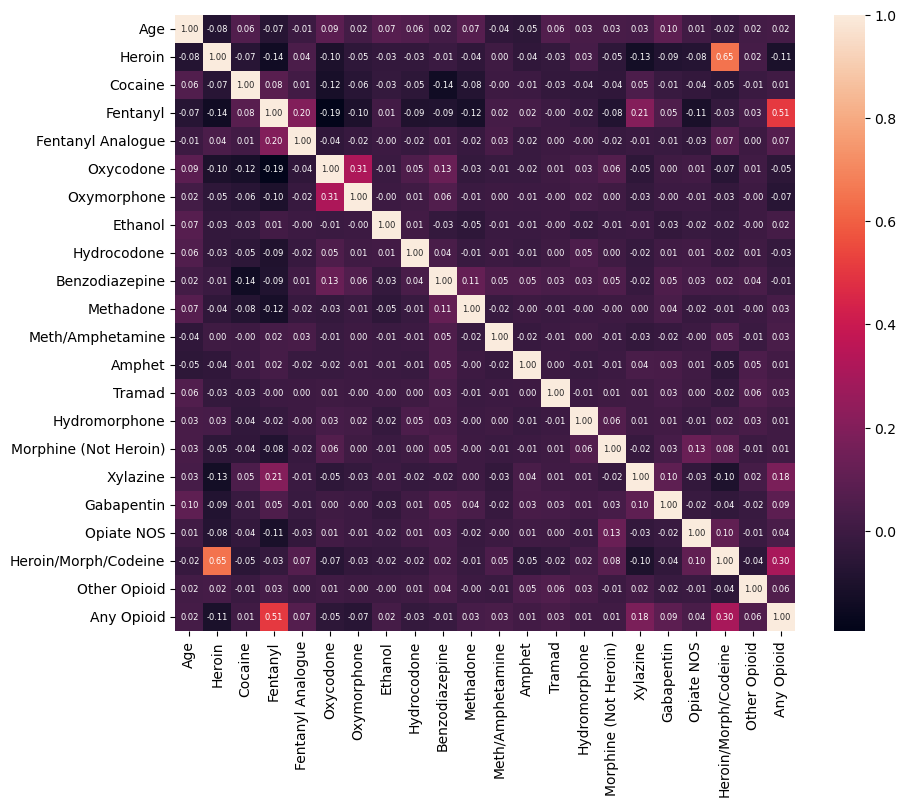

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(new_df.corr(), annot=True, annot_kws={"size": 6}, fmt='.2f')
plt.show()

In [29]:
import plotly.express as px
#need to group by Date and sum/average detections
time_data = new_df.groupby('Date')[drug_columns].sum().reset_index()
# Create a line graph
fig = px.line(time_data, x='Date', y=drug_columns, title='Trend of Drug Detections Over Time')
fig.show()


In [30]:
new_df.head()

_id        Date      Date Type  Age     Sex   Race  \
0  66340f10bd3c558ccdc8603c  05/29/2012  Date of death   37    Male  Black   
1  66340f10bd3c558ccdc8603d  06/27/2012  Date of death   37    Male  White   
2  66340f10bd3c558ccdc8603e  03/24/2014  Date of death   28    Male  White   
3  66340f10bd3c558ccdc8603f  12/31/2014  Date of death   26  Female  White   
4  66340f10bd3c558ccdc86040  01/16/2016  Date of death   41    Male  White   

  Ethnicity Residence State Injury State Description of Injury  ... Tramad  \
0      None            None           CT          Used Cocaine  ...      0   
1      None            None           CT              Drug Use  ...      0   
2      None            None           CT              Drug Use  ...      0   
3      None            None         None                  None  ...      0   
4      None              CT         None              Drug Use  ...      0   

  Hydromorphone Morphine (Not Heroin) Xylazine Gabapentin  Opiate NOS  \
0             0                     0        0          0           0   
1             0                     0        0          0           0   
2             0                     0        0          0           0   
3             0                     0        0          0           0   
4             0                     0        0          0           0   

   Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  
0                     0             0           0   None  
1                     0             0           0   None  
2                     0             0           0   None  
3                     0             0           0   None  
4                     0             0           1   None  

[5 rows x 37 columns]

In [31]:
new_df.fillna('None', inplace=True)

In [32]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10654 entries, 0 to 10653
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   _id                            10654 non-null  object
 1   Date                           10654 non-null  object
 2   Date Type                      10654 non-null  object
 3   Age                            10654 non-null  int32 
 4   Sex                            10654 non-null  object
 5   Race                           10654 non-null  object
 6   Ethnicity                      10654 non-null  object
 7   Residence State                10654 non-null  object
 8   Injury State                   10654 non-null  object
 9   Description of Injury          10654 non-null  object
 10  Death State                    10654 non-null  object
 11  Location                       10654 non-null  object
 12  Cause of Death                 10654 non-null  object
 13  M

In [33]:
#might have to do binning for age 
new_df.head()

_id        Date      Date Type  Age     Sex   Race  \
0  66340f10bd3c558ccdc8603c  05/29/2012  Date of death   37    Male  Black   
1  66340f10bd3c558ccdc8603d  06/27/2012  Date of death   37    Male  White   
2  66340f10bd3c558ccdc8603e  03/24/2014  Date of death   28    Male  White   
3  66340f10bd3c558ccdc8603f  12/31/2014  Date of death   26  Female  White   
4  66340f10bd3c558ccdc86040  01/16/2016  Date of death   41    Male  White   

  Ethnicity Residence State Injury State Description of Injury  ... Tramad  \
0      None            None           CT          Used Cocaine  ...      0   
1      None            None           CT              Drug Use  ...      0   
2      None            None           CT              Drug Use  ...      0   
3      None            None         None                  None  ...      0   
4      None              CT         None              Drug Use  ...      0   

  Hydromorphone Morphine (Not Heroin) Xylazine Gabapentin  Opiate NOS  \
0             0                     0        0          0           0   
1             0                     0        0          0           0   
2             0                     0        0          0           0   
3             0                     0        0          0           0   
4             0                     0        0          0           0   

   Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  
0                     0             0           0   None  
1                     0             0           0   None  
2                     0             0           0   None  
3                     0             0           0   None  
4                     0             0           1   None  

[5 rows x 37 columns]

<Axes: >

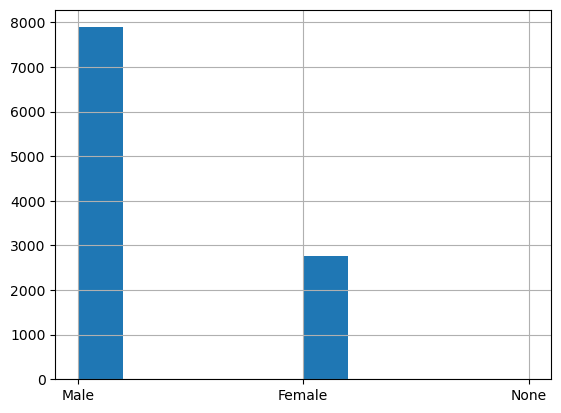

In [34]:
new_df['Sex'].hist()

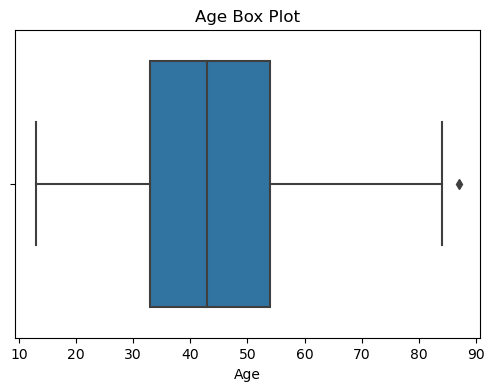

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Age'])
plt.title('Age Box Plot')
plt.xlabel('Age')
plt.show()


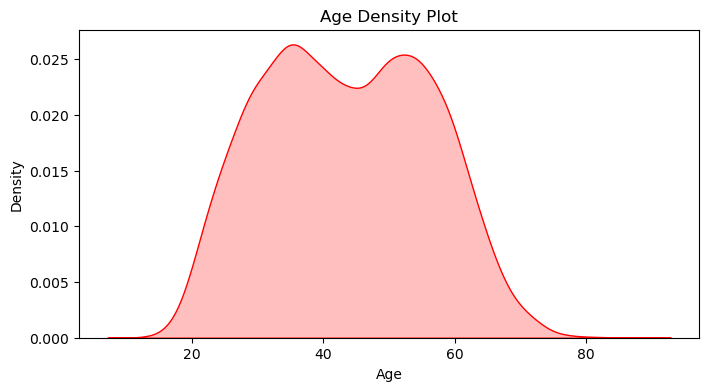

In [36]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df['Age'], shade=True, color="r")
plt.title('Age Density Plot')
plt.xlabel('Age')
plt.show()


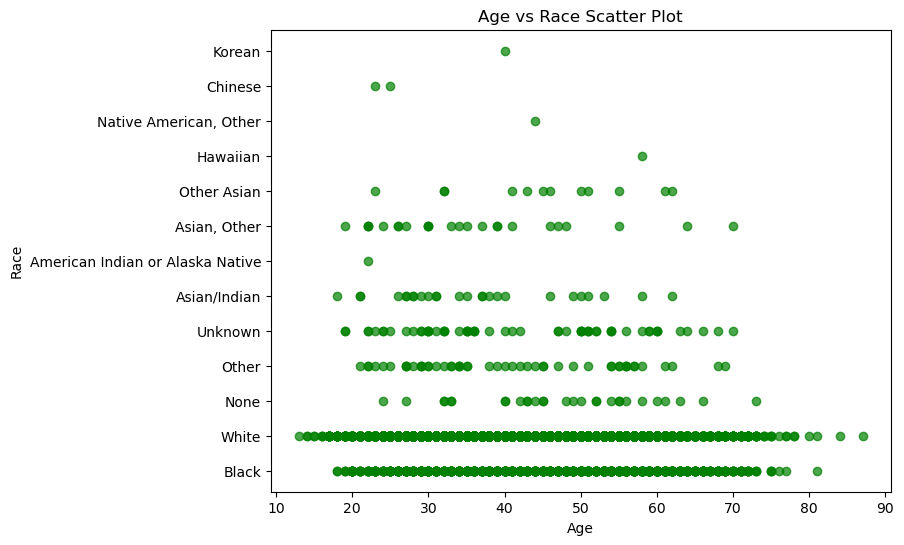

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(x=new_df['Age'], y=new_df['Race'], alpha=0.7, color='green')
plt.title('Age vs Race Scatter Plot')
plt.xlabel('Age')
plt.ylabel('Race')
plt.show()


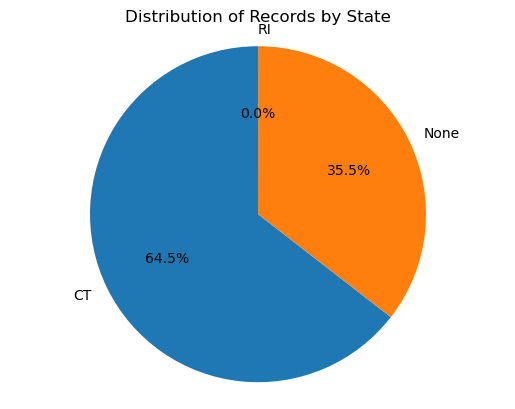

In [38]:
state_counts = new_df['Death State'].value_counts()
fig, ax = plt.subplots()
ax.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Records by State")
plt.show()


In [39]:
df2=new_df
df2.head()

_id        Date      Date Type  Age     Sex   Race  \
0  66340f10bd3c558ccdc8603c  05/29/2012  Date of death   37    Male  Black   
1  66340f10bd3c558ccdc8603d  06/27/2012  Date of death   37    Male  White   
2  66340f10bd3c558ccdc8603e  03/24/2014  Date of death   28    Male  White   
3  66340f10bd3c558ccdc8603f  12/31/2014  Date of death   26  Female  White   
4  66340f10bd3c558ccdc86040  01/16/2016  Date of death   41    Male  White   

  Ethnicity Residence State Injury State Description of Injury  ... Tramad  \
0      None            None           CT          Used Cocaine  ...      0   
1      None            None           CT              Drug Use  ...      0   
2      None            None           CT              Drug Use  ...      0   
3      None            None         None                  None  ...      0   
4      None              CT         None              Drug Use  ...      0   

  Hydromorphone Morphine (Not Heroin) Xylazine Gabapentin  Opiate NOS  \
0             0                     0        0          0           0   
1             0                     0        0          0           0   
2             0                     0        0          0           0   
3             0                     0        0          0           0   
4             0                     0        0          0           0   

   Heroin/Morph/Codeine  Other Opioid  Any Opioid  Other  
0                     0             0           0   None  
1                     0             0           0   None  
2                     0             0           0   None  
3                     0             0           0   None  
4                     0             0           1   None  

[5 rows x 37 columns]

In [40]:
df2.corr()

Age    Heroin   Cocaine  Fentanyl  \
Age                    1.000000 -0.079543  0.058550 -0.068972   
Heroin                -0.079543  1.000000 -0.065968 -0.142360   
Cocaine                0.058550 -0.065968  1.000000  0.080669   
Fentanyl              -0.068972 -0.142360  0.080669  1.000000   
Fentanyl Analogue     -0.005478  0.043204  0.014852  0.200798   
Oxycodone              0.087554 -0.103712 -0.119083 -0.194225   
Oxymorphone            0.018430 -0.048470 -0.064531 -0.101273   
Ethanol                0.072277 -0.032736 -0.027718  0.012195   
Hydrocodone            0.061542 -0.032826 -0.054074 -0.092846   
Benzodiazepine         0.018170 -0.009165 -0.140704 -0.090949   
Methadone              0.072578 -0.043593 -0.080930 -0.116322   
Meth/Amphetamine      -0.041968  0.004820 -0.001716  0.022617   
Amphet                -0.051560 -0.043274 -0.005303  0.022594   
Tramad                 0.058117 -0.029280 -0.031239 -0.004329   
Hydromorphone          0.030106  0.025752 -0.037664 -0.023737   
Morphine (Not Heroin)  0.030058 -0.048694 -0.044327 -0.084105   
Xylazine               0.028141 -0.132147  0.046483  0.205789   
Gabapentin             0.097580 -0.085833 -0.012717  0.050456   
Opiate NOS             0.007103 -0.076064 -0.035398 -0.114439   
Heroin/Morph/Codeine  -0.019418  0.647077 -0.054534 -0.027402   
Other Opioid           0.016981  0.023347 -0.009743  0.029062   
Any Opioid             0.022715 -0.108029  0.008954  0.509564   

                       Fentanyl Analogue  Oxycodone  Oxymorphone   Ethanol  \
Age                            -0.005478   0.087554     0.018430  0.072277   
Heroin                          0.043204  -0.103712    -0.048470 -0.032736   
Cocaine                         0.014852  -0.119083    -0.064531 -0.027718   
Fentanyl                        0.200798  -0.194225    -0.101273  0.012195   
Fentanyl Analogue               1.000000  -0.043256    -0.020195 -0.003291   
Oxycodone                      -0.043256   1.000000     0.314335 -0.010784   
Oxymorphone                    -0.020195   0.314335     1.000000 -0.004204   
Ethanol                        -0.003291  -0.010784    -0.004204  1.000000   
Hydrocodone                    -0.018241   0.049549     0.010142  0.013751   
Benzodiazepine                  0.007056   0.126051     0.060987 -0.029351   
Methadone                      -0.019796  -0.029802    -0.010509 -0.048717   
Meth/Amphetamine                0.030830  -0.013123     0.000922 -0.012262   
Amphet                         -0.015935  -0.016448    -0.005570 -0.010479   
Tramad                          0.001253   0.005472    -0.000895 -0.002220   
Hydromorphone                  -0.000252   0.029271     0.019833 -0.024317   
Morphine (Not Heroin)          -0.020009   0.063153     0.002612 -0.012261   
Xylazine                       -0.007813  -0.047235    -0.028718 -0.006344   
Gabapentin                     -0.014386   0.003820    -0.004886 -0.031804   
Opiate NOS                     -0.031255   0.014516    -0.006174 -0.015694   
Heroin/Morph/Codeine            0.069183  -0.066358    -0.031915 -0.023743   
Other Opioid                    0.000808   0.010705    -0.002777 -0.000701   
Any Opioid                      0.071251  -0.052320    -0.065834  0.022682   

                       Hydrocodone  Benzodiazepine  ...    Amphet    Tramad  \
Age                       0.061542        0.018170  ... -0.051560  0.058117   
Heroin                   -0.032826       -0.009165  ... -0.043274 -0.029280   
Cocaine                  -0.054074       -0.140704  ... -0.005303 -0.031239   
Fentanyl                 -0.092846       -0.090949  ...  0.022594 -0.004329   
Fentanyl Analogue        -0.018241        0.007056  ... -0.015935  0.001253   
Oxycodone                 0.049549        0.126051  ... -0.016448  0.005472   
Oxymorphone               0.010142        0.060987  ... -0.005570 -0.000895   
Ethanol                   0.013751       -0.029351  ... -0.010479 -0.002220   
Hydrocodone               

In [41]:
from sklearn.cluster import KMeans
# Handle missing values if any (assuming none for this example)
# df2['Age'].dropna(inplace=True)  # Uncomment this line if there are missing values
# Elbow Method to determine the optimal number of clusters
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df2[['Age']])
    inertia.append(kmeans.inertia_)

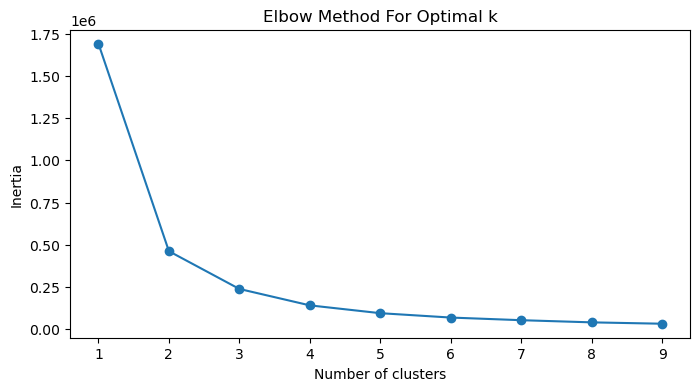

In [42]:
# Plotting the Elbow graph
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [43]:
# Applying K-Means with an assumed optimal number of clusters
# Let's assume 3 clusters from the elbow method observation
kmeans = KMeans(n_clusters=3, random_state=42)
df2['Cluster'] = kmeans.fit_predict(df2[['Age']])

         min  max       mean  count
Cluster                            
0         37   50  43.445328   3521
1         13   36  29.379627   3593
2         51   87  57.931921   3540


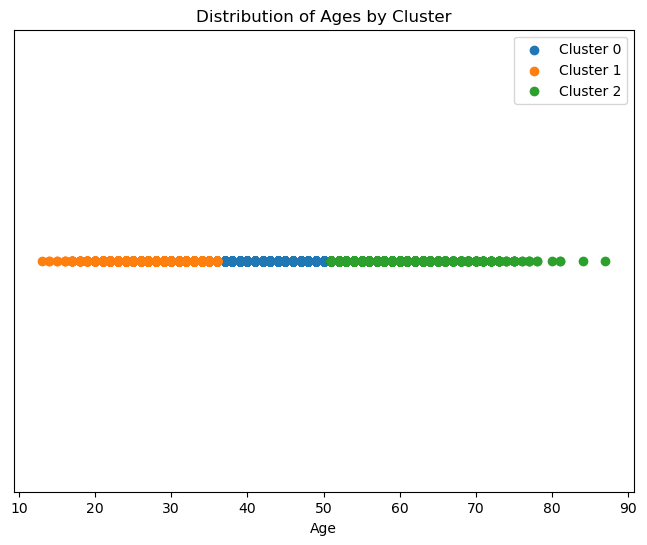

In [44]:
# Analyze the clusters
print(df2.groupby('Cluster')['Age'].agg(['min', 'max', 'mean', 'count']))
# Visualizing the clusters
plt.figure(figsize=(8, 6))
for cluster in df2['Cluster'].unique():
    cluster_group = df2[df2['Cluster'] == cluster]
    plt.scatter(cluster_group['Age'], np.zeros_like(cluster_group['Age']), label=f'Cluster {cluster}')
plt.xlabel('Age')
plt.yticks([])
plt.title('Distribution of Ages by Cluster')
plt.legend()
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Define categorical and numeric columns
categorical_cols = ['Sex']
numeric_cols = ['Age']
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [46]:
# Fit and transform the data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_processed = pipeline.fit_transform(df2)

In [47]:
# Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df2['Cluster'] = kmeans.fit_predict(X_processed)

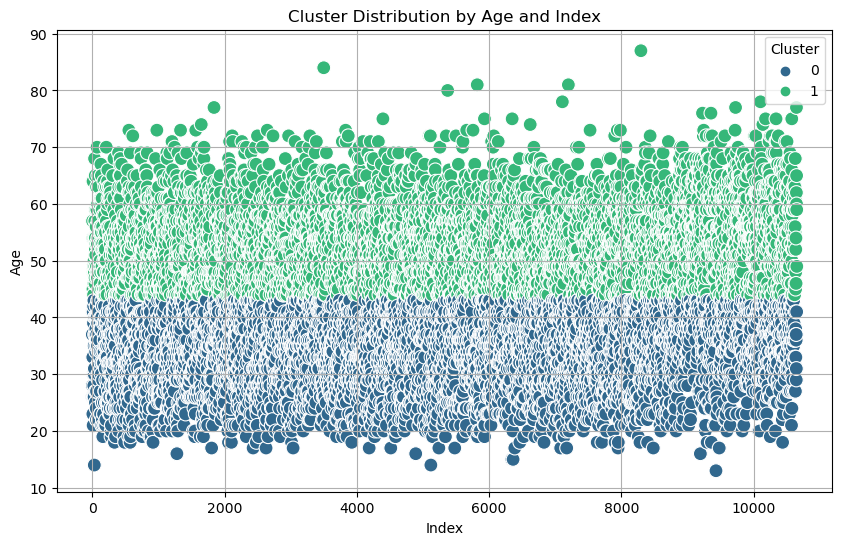

In [48]:
# Plotting the results
# Since we only have one numeric attribute ('Age'), let's visualize it against the index
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df2.index, y='Age', hue='Cluster', data=df2, palette='viridis', s=100)
plt.title('Cluster Distribution by Age and Index')
plt.xlabel('Index')
plt.ylabel('Age')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
# If more numeric attributes were available, consider pair plots or 3D plots

### Data to be Dumped in postgresql

In [49]:
 new_df.dtypes

_id                              object
Date                             object
Date Type                        object
Age                               int32
Sex                              object
Race                             object
Ethnicity                        object
Residence State                  object
Injury State                     object
Description of Injury            object
Death State                      object
Location                         object
Cause of Death                   object
Manner of Death                  object
Other Significant Conditions     object
Heroin                            int32
Cocaine                           int32
Fentanyl                          int32
Fentanyl Analogue                 int32
Oxycodone                         int32
Oxymorphone                       int32
Ethanol                           int32
Hydrocodone                       int32
Benzodiazepine                    int32
Methadone                         int32


In [50]:
#First we have to convert all the dtype into str as postgresql does not accept the float dtype
new_df['_id'] = new_df['_id'].astype(str)
new_df['Date'] = new_df['Date'].astype(str)
new_df['Date Type'] = new_df['Date Type'].astype(str)
new_df['Sex'] = new_df['Sex'].astype(str)
new_df['Race'] = new_df['Race'].astype(str)
new_df['Residence State'] = new_df['Residence State'].astype(str)
new_df['Ethnicity'] = new_df['Ethnicity'].astype(str)
new_df['Injury State'] = new_df['Injury State'].astype(str)
new_df['Description of Injury'] = new_df['Description of Injury'].astype(str)
new_df['Death State'] = new_df['Death State'].astype(str)
new_df['Location'] = new_df['Location'].astype(str)
new_df['Cause of Death'] = new_df['Cause of Death'].astype(str)
new_df['Manner of Death'] = new_df['Manner of Death'].astype(str)
new_df['Other'] = new_df['Other'].astype(str)

In [51]:
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine

In [52]:
# Connection parameters for PostgreSQL
database = {
    "host": "localhost",
    "port": "5432",
    "user": "postgres",
    "password": "Mypassword07"
}

In [53]:
# Establish a connection to the PostgreSQL server
try:
    conn = psycopg2.connect(**database)
    conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    # Creating a cursor to perform database operations
    cur = conn.cursor()
    # Fisrt it will check if the 'DAP Project' database already exists,
    #if not it will create the database
    cur.execute("SELECT 1 FROM pg_database WHERE datname='DAP Project';")
    exists = cur.fetchone()
    if not exists:
        cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier('DAP Project')))
        print("Database 'DAP Project' was successfully created.")
    else:
        print("Database 'DAP Project' already exists. No action was taken.")
except psycopg2.Error as e:
    print("An error occurred: ", e)
finally:
    if cur:
        cur.close()
    if conn:
        conn.close()
print("Finished checking and potentially creating the 'DAP Poject database.")

Database 'DAP Project' already exists. No action was taken.
Finished checking and potentially creating the 'DAP Poject database.


In [54]:
# Create the database engine
# PostgreSQL connection parameters
username = 'postgres'
password = 'Mypassword07'
host = 'localhost'
port = '5432'
database = 'DAP Project'
engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')

In [55]:
#Finally our all connection setup is done and now by using the 'to_sql' will dump all the
#data in database
new_df.to_sql('Accidential Data', con=engine, index=False, if_exists='replace')

654